# 06 - Spotify Audio Features Exploratory Data Analysis

In [28]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation, KernelPCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Load data

In [32]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
1822,gerry rafferty,gerry rafferty,26,baker street,1978,NaN,baker street,gerry rafferty,windin your way down on baker street light in...,0.09290,...,0.0297,113.762,4.0,0.421,6.093783,226.0,0.618116,119.0,1970,1.899160
3826,missy elliott featuring da brat,missy elliott,93,sock it 2 me,1998,da brat,sock it 2 me,missy elliott,do it do it do it do it do it no no no i was ...,0.00791,...,0.2330,81.998,4.0,0.599,4.291117,596.0,2.314860,213.0,1990,2.798122
4451,gavin degraw,gavin degraw,58,i don't want to be,2005,NaN,i dont want to be,gavin degraw,i dont need to be anything other than a priso...,0.00791,...,0.0695,154.746,4.0,0.462,3.629333,342.0,1.570536,94.0,2000,3.638298


## Univariate distributions

In [34]:
df.columns

Index(['artist_all', 'artist_base', 'rank', 'song', 'year', 'artist_featured',
       'song_clean', 'artist_clean', 'lyrics', 'acousticness', 'danceability',
       'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'popularity', 'release_date', 'speechiness', 'tempo',
       'time_signature', 'valence', 'duration_min', 'num_words',
       'words_per_sec', 'num_uniq_words', 'decade', 'uniq_ratio'],
      dtype='object')

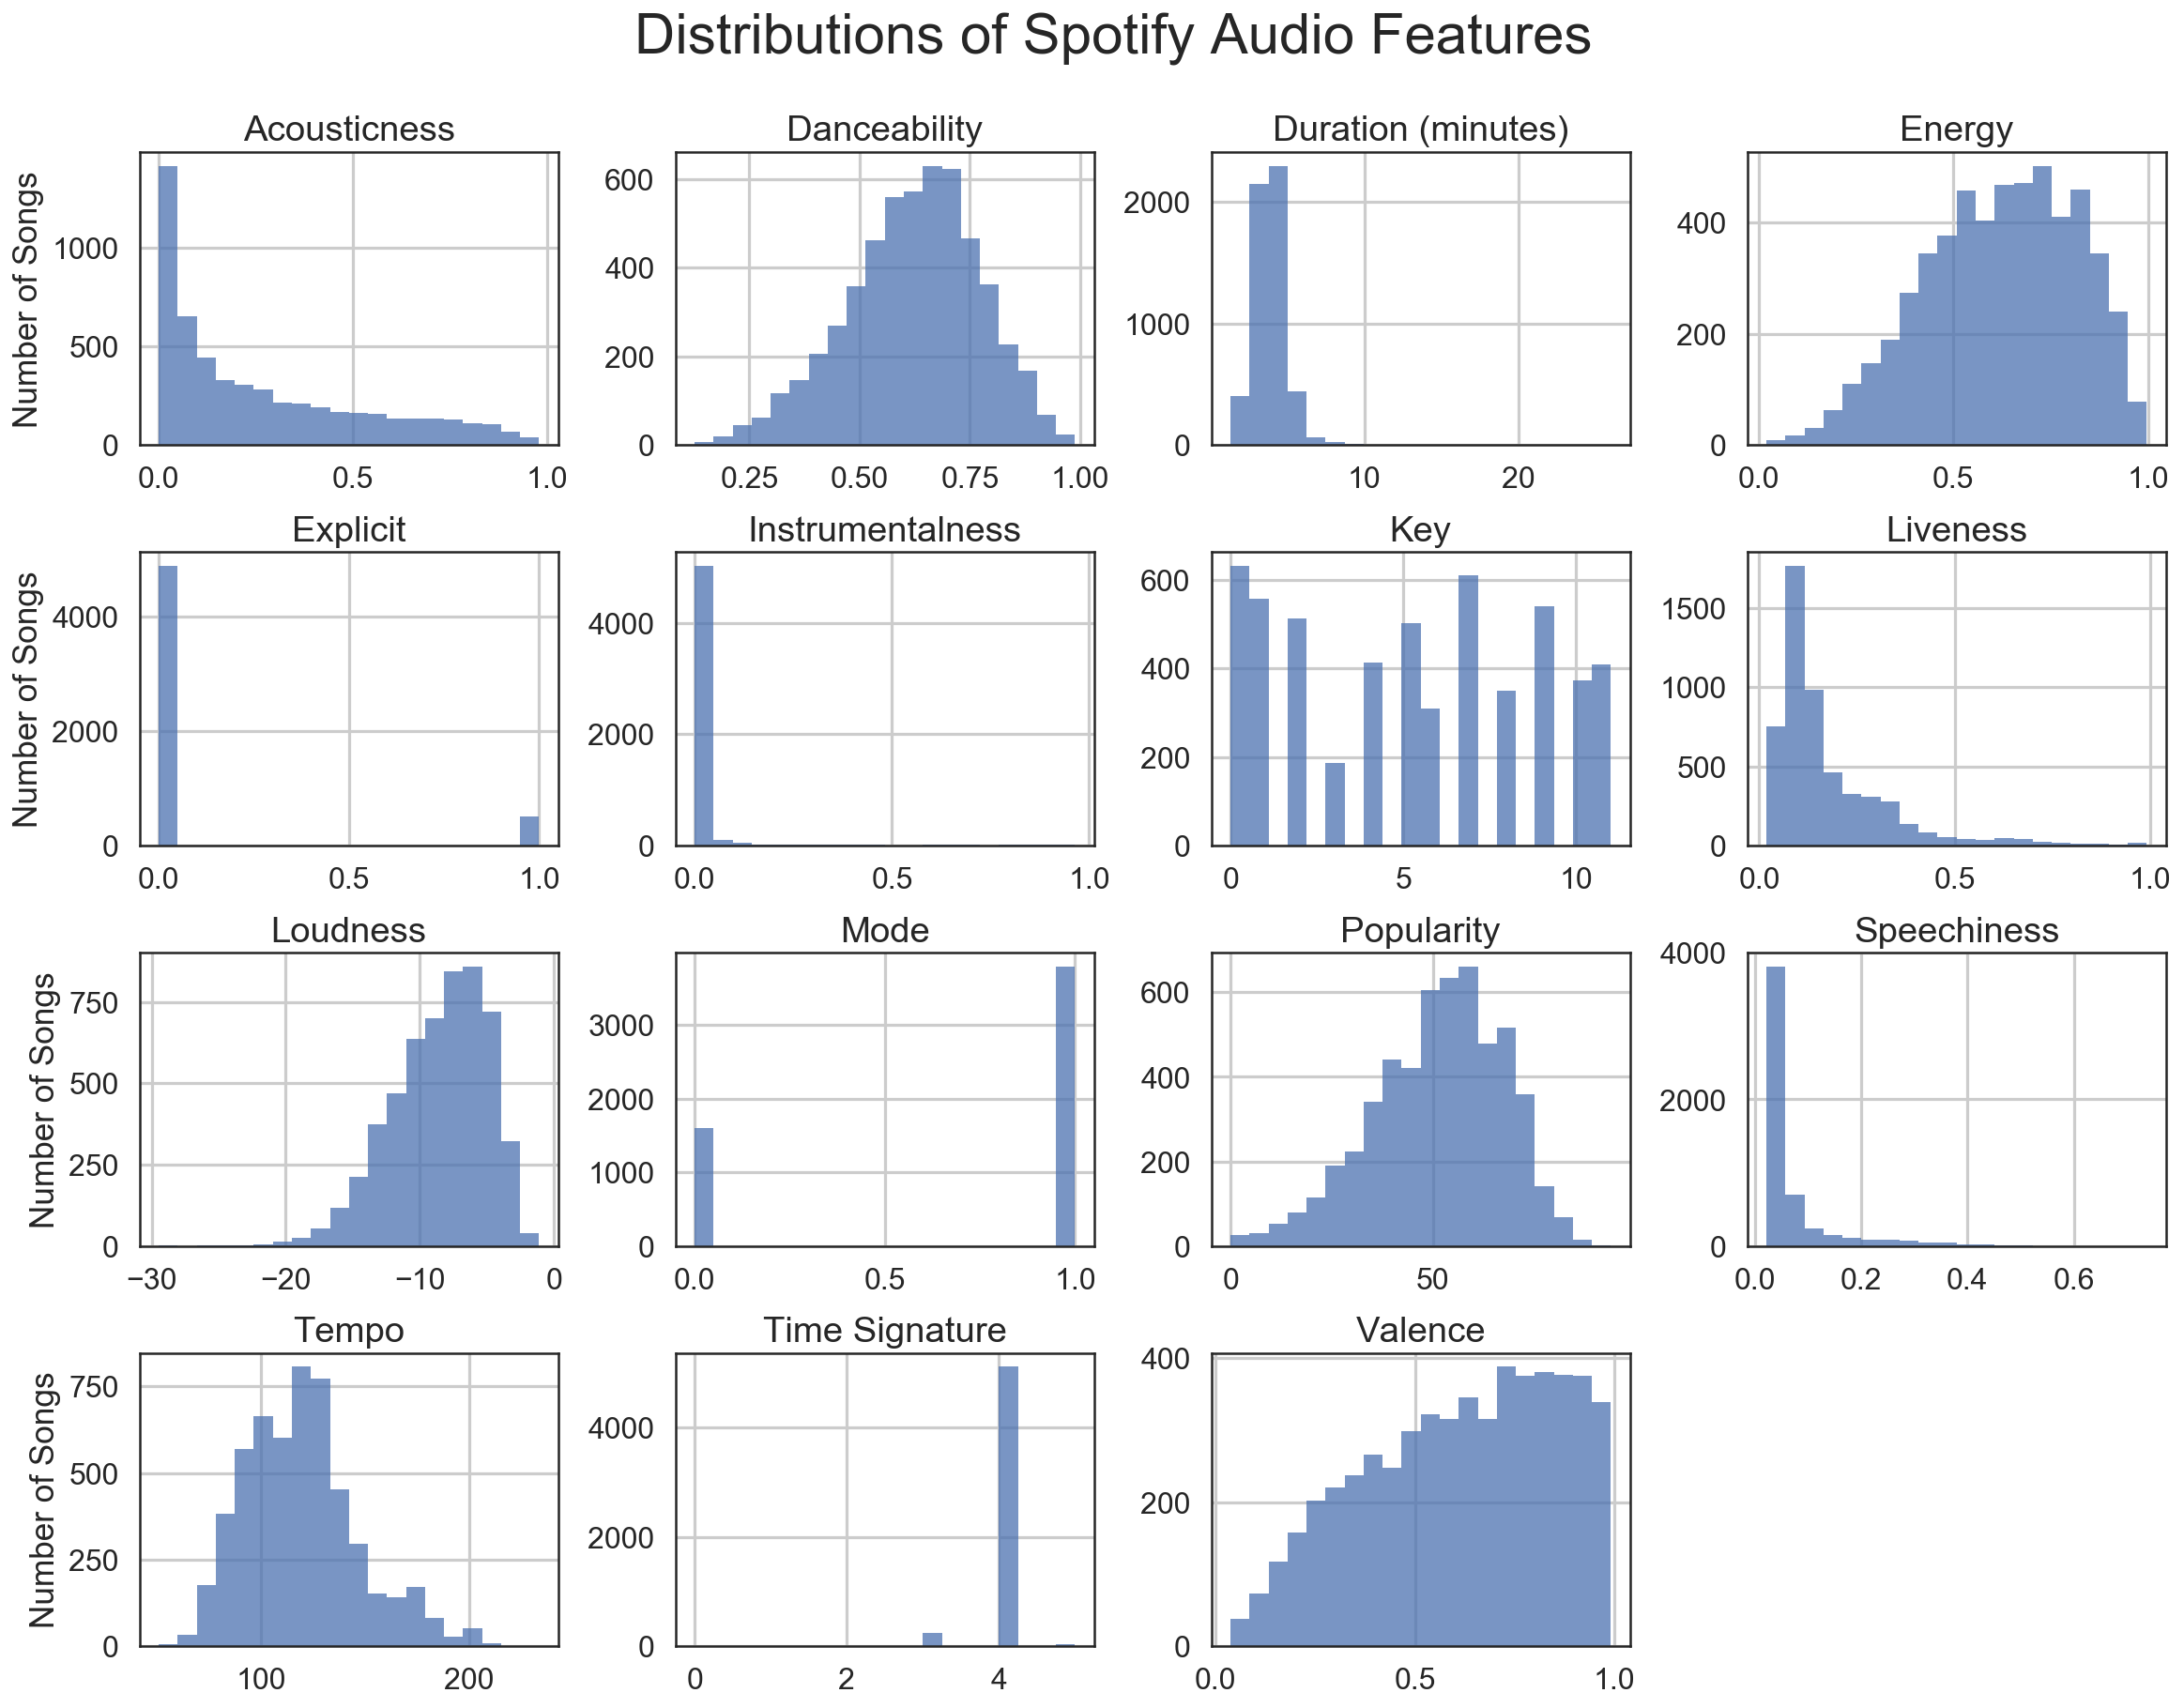

In [36]:
axes = df.drop(['year', 'rank', 'num_words', 'uniq_ratio', 'decade',
                'num_uniq_words', 'words_per_sec'], axis=1)\
         .hist(figsize=(16,12), bins=20, alpha=0.75);
axes = axes.ravel()
plt.tight_layout()

titles = ['Acousticness', 'Danceability', 'Duration (minutes)', 'Energy',
          'Explicit', 'Instrumentalness', 'Key', 'Liveness', 'Loudness', 'Mode',
          'Popularity', 'Speechiness', 'Tempo', 'Time Signature', 'Valence']
for i in range(len(axes)-1):
    axes[i].set_title(titles[i])
    if i % 4 == 0:
        axes[i].set_ylabel('Number of Songs')
plt.suptitle('Distributions of Spotify Audio Features', fontsize=30, y=1.05);

In [160]:
df[df['duration_min'] > 20]

,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,liveness,loudness,mode,popularity,release_date,speechiness,tempo,time_signature,valence,duration_min
1479,mike oldfield,mike oldfield,79,tubular bells,1974,NaN,tubular bells,mike oldfield,spoken grand piano reed and pipe organ glocken...,0.558,...,0.111,-19.087,0.0,33.0,1973-02-01,0.0364,103.516,4.0,0.0574,26.018883


## Correlation heatmap 

Text(0.5,0.91,'Correlation Matrix Heatmap')

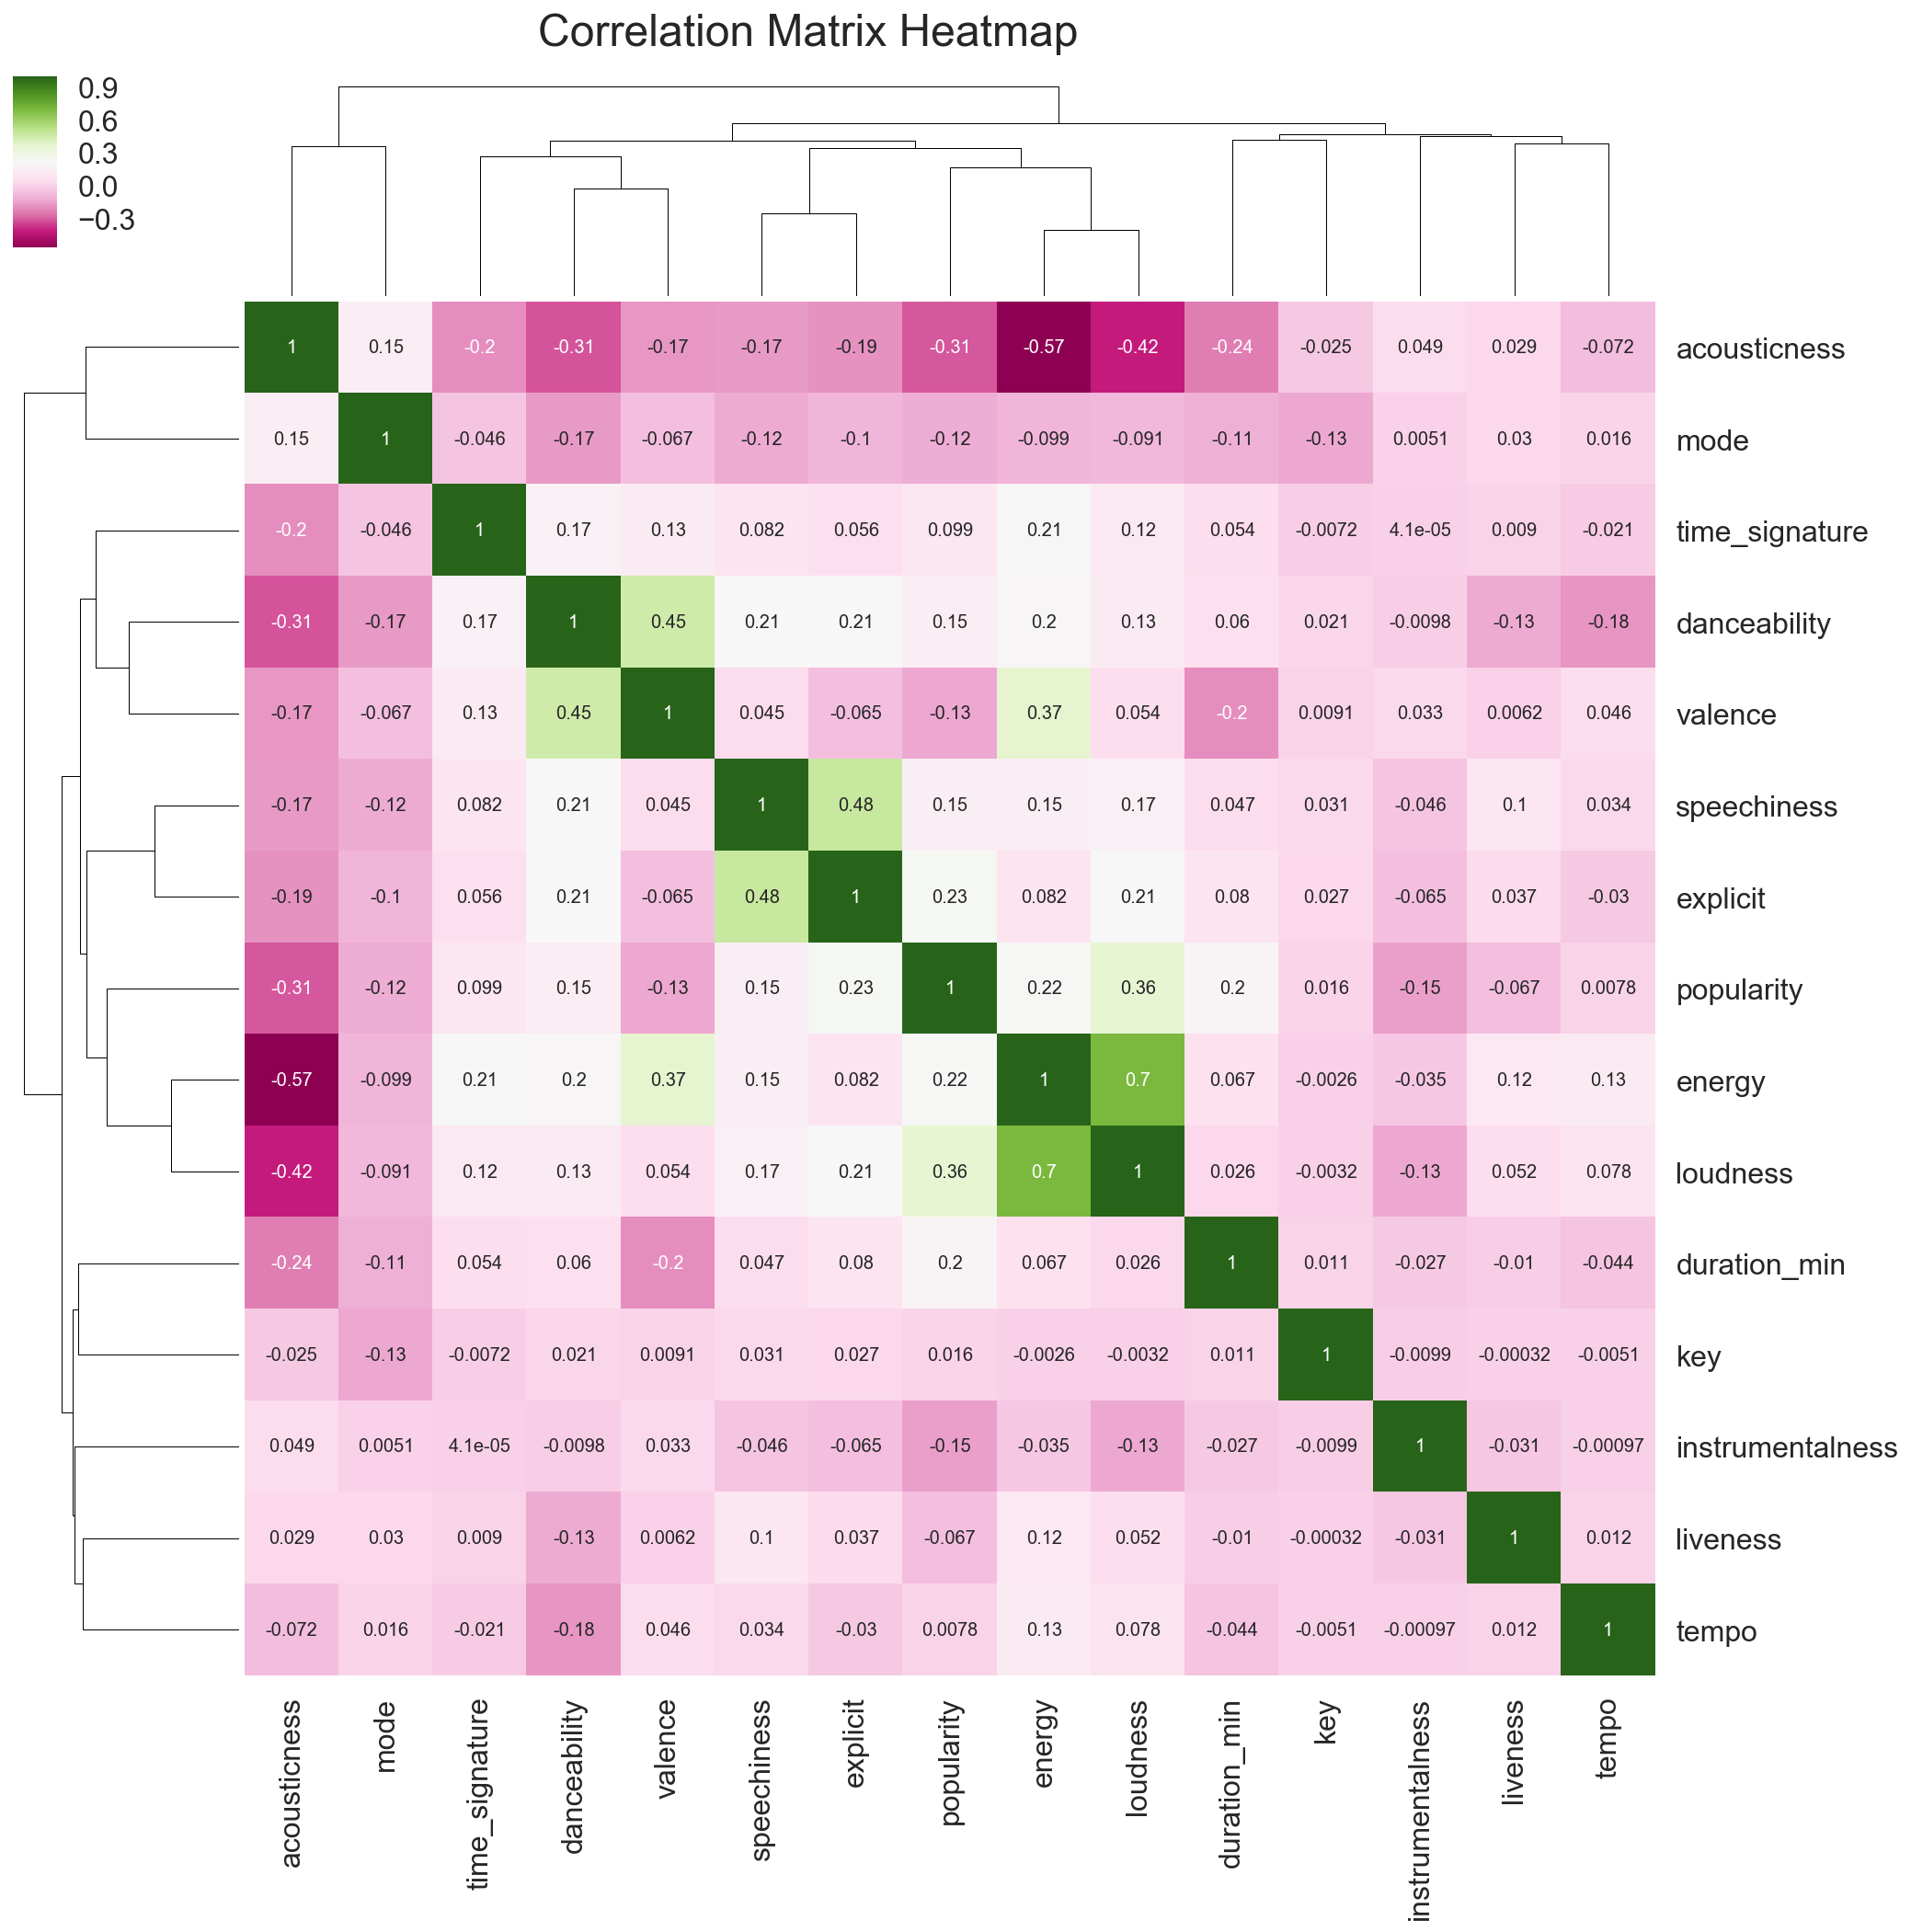

In [42]:
columns = ['acousticness', 'danceability', 'duration_min', 'energy',
           'instrumentalness', 'liveness', 'loudness', 'popularity',
           'speechiness', 'tempo', 'valence', 'time_signature', 'mode',
           'key', 'explicit']
df_scatter = df[columns]
sns.clustermap(df_scatter.corr(), cmap='PiYG', annot=True, figsize=(16,16))
plt.suptitle('Correlation Matrix Heatmap', fontsize=24, y=0.91)

## Bivariate distributions

Text(0.5,1.05,'Closely Related Audio Features')

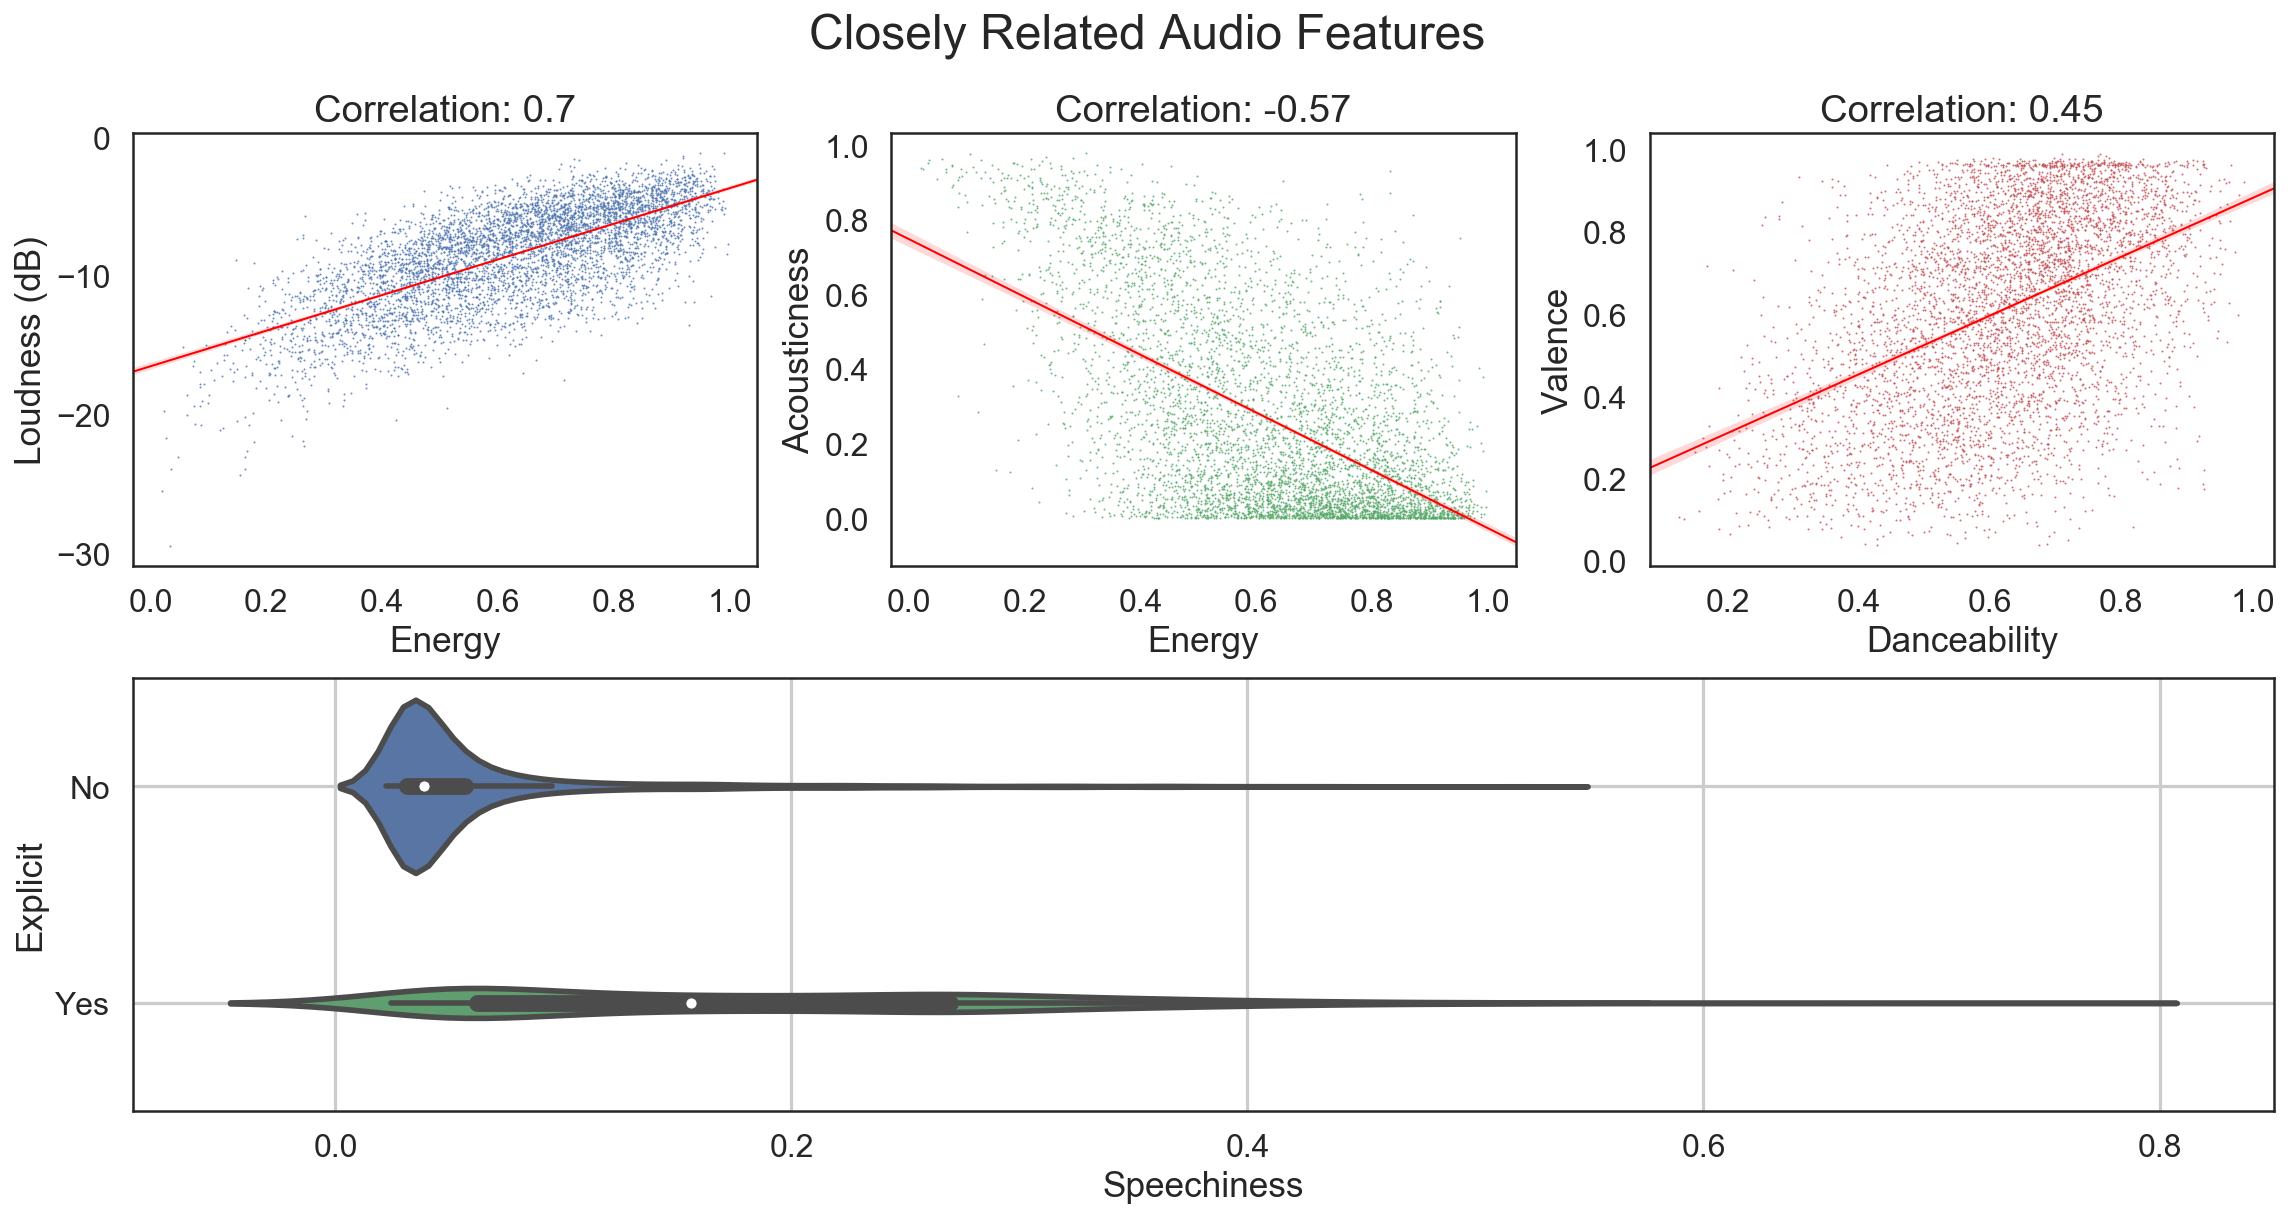

In [49]:
# generate subplot axes
axes = list()
plt.figure(figsize = (16,8))
grid_positions = [231, 232, 233, 212]
for position in grid_positions:
    axes.append(plt.subplot(position))
    
feature_pairs = [('energy', 'loudness'), ('energy', 'acousticness'),
                 ('danceability', 'valence')]

# generate upper scatter plots
for (x, y), ax in zip(feature_pairs, axes[:3]):
    r = np.corrcoef(df[x].dropna(), df[y].dropna())[0][1]
    sns.regplot(data=df, x=x, y=y, line_kws= {'linewidth': 1, 'color': 'red'},
                scatter_kws={'s': 1}, label='test', ax=ax)
    ax.set(title='Correlation: {:.2}'.format(r))
axes[0].set(ylabel='Loudness (dB)', xlabel='Energy')
axes[1].set(ylabel='Acousticness', xlabel='Energy')
axes[2].set(ylabel='Valence', xlabel='Danceability')


# generate lower violin plot
sns.violinplot(data=df, x='speechiness', y='explicit', orient='horizontal',
               split=True, ax=axes[3])
axes[3].grid(True)
axes[3].set(ylabel='Explicit', xlabel='Speechiness')
axes[3].set_yticks([0,1])
axes[3].set_yticklabels(['No', 'Yes'])

plt.tight_layout()
plt.suptitle('Closely Related Audio Features', fontsize=24, y=1.05)